In [3]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('../src')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [4]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [8]:

# setting up the problem
perceptron_qubits = 8
fourier_basis = 2
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, fourier_basis, basis='gaussian', pulse_width=0.5e-2)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')
    



Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (0.1) [X4]
+ (0.1) [X5]
+ (0.1) [X6]
+ (0.1) [X7]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
+ (1.0) [Z3 Z4]
+ (1.0) [Z4 Z5]
+ (1.0) [Z5 Z6]
+ (1.0) [Z6 Z7]
Exact ground state energy: -7.025018814832985


/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [9]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.65008684 0.88351328 0.44394031 0.38719628 0.8525457  0.79895675
 0.60568009 0.54269114 0.97001245 0.47524098 0.15231487 0.66797508
 0.33766942 0.40026932 0.04465917 0.67081904 0.13948173 0.11202985
 0.51406501 0.28521366 0.01935501 0.68400932 0.22663391 0.58721672
 0.7913039  0.35559591 0.70809012 0.0142391  0.40758245 0.32834776
 0.77251635 0.79562901 0.35215985 0.48260399 0.19618129 0.98270955
 0.82672937 0.20451467 0.69241239]
Initial loss: 1.8090840202350242
Initial gradients: [-0.18197248 -0.2506222   0.0905861   0.06759457 -0.36169023 -0.39629932
 -0.02186745 -0.75231258 -0.66552554 -0.25632975  0.6239601   1.16515739
  1.6437315  -0.34678408  0.93179685  0.03884453  0.40210635  2.16768135
  1.27247198 -0.46104362  0.32999351 -0.49494824  0.48409339 -0.91905795
 -0.55554865  0.6667988   0.63822238  1.03232528  0.23350186  1.54712265
  1.1930092   0.31307296 -0.07514644  1.12437553  2.37062883 -0.57131348
 -0.47316568  0.15909902  0.50015525]


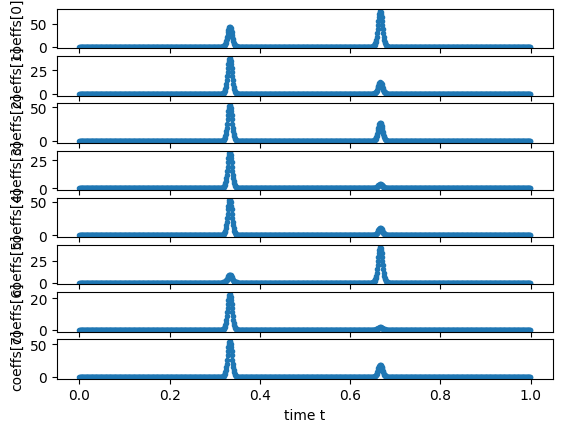

In [10]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [6]:

from datetime import datetime

n_epochs = 100
param_vector = perceptron.get_random_parameter_vector(0)

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(1e-1)
# schedule1 = optax.constant_schedule(5e-1)
# schedule = optax.join_schedules([schedule0, schedule1], [20])
# optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energy = np.zeros(n_epochs + 1)
energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(param_vector)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)
    param_vector = optax.apply_updates(param_vector, updates)

    mean_gradients[n] = np.mean(np.abs(grads))
    energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")



print(f"Found ground state: {energy[-1]}")


grad and val compilation time: 0:01:17.023557
1 / 100; energy discrepancy: 7.5932070607508635
mean grad: 0.23587506572933864
11 / 100; energy discrepancy: 6.88509183279479
mean grad: 0.21647013064106915
21 / 100; energy discrepancy: 3.3535767340098226
mean grad: 0.4194708937398323
31 / 100; energy discrepancy: 4.9973757363917475
mean grad: 0.19401604648001952
41 / 100; energy discrepancy: 4.031281927386878
mean grad: 0.31883968220149633
51 / 100; energy discrepancy: 2.6908093005157028
mean grad: 0.21620605168866874
61 / 100; energy discrepancy: 2.081339456612774
mean grad: 0.11177032174837083
71 / 100; energy discrepancy: 1.9878070544793474
mean grad: 0.06208991473145802
81 / 100; energy discrepancy: 2.128388197877036
mean grad: 0.14496506977267826
91 / 100; energy discrepancy: 1.9495850470506486
mean grad: 0.058225527968432
Found ground state: -5.09933942244086


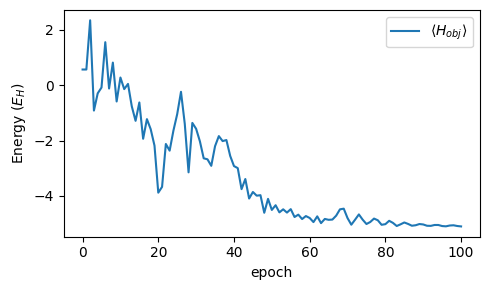

In [7]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

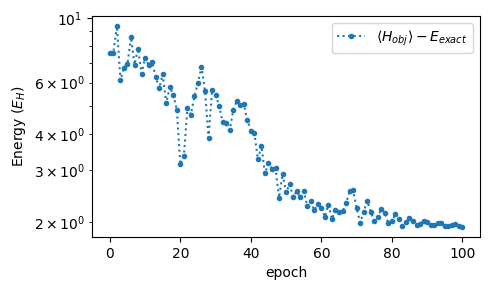

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

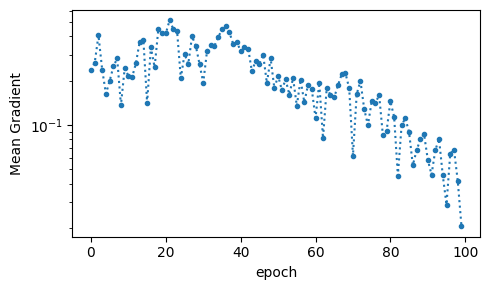

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

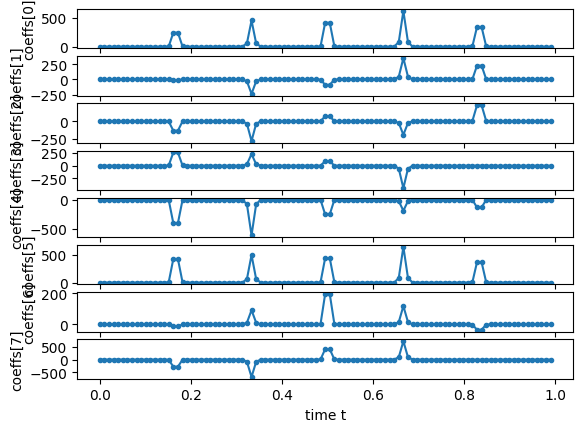

In [10]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [23]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

KeyboardInterrupt: 

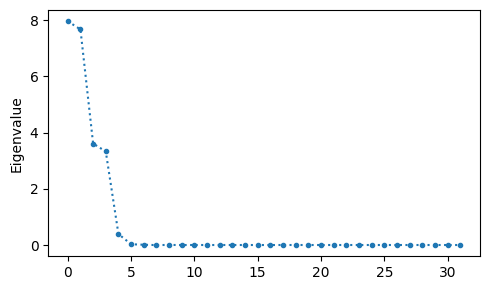

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()